In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Input, Flatten, concatenate,LSTM,Dropout
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/sentiment_hotel_data.csv')
#data['Label'] = data['overall'].apply(lambda x : 1 if x>3.5 else(0 if ))
data = data.sample(frac=1)
data.head()

,Unnamed: 0,text,overall
57259,83028,This was my third stay at the Hudson in three ...,2.0
42140,340771,I recently stayed at the hotel for business an...,5.0
24817,681238,The Inn at the Market is the best hotel/inn I ...,5.0
28005,279624,I stayed at this hotel for 1 night prior to fl...,2.0
74198,578233,Stayed at the Fairfield Inn & Suites for the I...,5.0


In [ ]:
pos_data = data[data['overall']>=3.5].iloc[:4500]
pos_data['Label'] = 1
neg_data = data[data['overall']<3].iloc[:4500]
neg_data['Label'] = 0

In [ ]:
data = pd.concat([pos_data,neg_data])
data = data.sample(frac=1)
data.head()

,Unnamed: 0,text,overall,Label
28724,84610,Booked room with two twin beds. Expected it to...,1.0,0
73799,458694,The good:\nExcellent staff--very helpful and f...,2.0,0
33594,30974,We had a week in NYC as our son's choir perfor...,4.0,1
92646,647067,This was my second time staying in this hotel....,4.0,1
1231,3301,"It's no wonder this hotel is always ""on sale""....",1.0,0


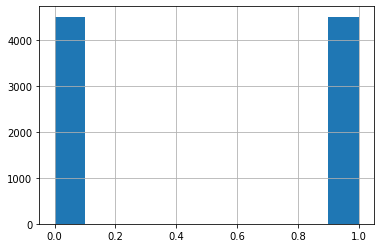

In [ ]:
data.Label.hist()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import re
def remove_punc(line):
  line = re.sub('[0-9@]', '',line)
  line = re.sub('[#[]', '',line)
  line = re.sub(']', '',line)
  line = re.sub('[\'":,.?!&)(]', '',line)
  line = line.rstrip().lstrip()
  return line

data['text'] = data['text'].apply(lambda x : remove_punc(x))
data.text.values

array(['Booked room with two twin beds Expected it to be small with no view but not the size of my closet Each bed had only one mattress on a board - no box springs The beds were about  inch apart and jammed against each wall - no room for bedside table - just a pole lamp between the two There was a small wardrobe and a small desk with a flat screen mounted on the wall We had to move the chair to in front of the wardrobe making it unusable in order to have room for our two suitcases on the floor One of us literally had to sit on our bed while the other moved around the small cramped room The lighting was really bad - two small pole lamps for the entire room - we kept bathroom lights on and door open to help us see to read Very very noisy a/c stuck in window inches away from me The bathroom was no wider than  feet with a sink mounted on the wall - no place to put your stuff except on the floor They blamed it on Cheaptickets and the difference between their definitions of deluxe They may

In [ ]:
import nltk
nltk.download('omw-1.4')  

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import nltk
from nltk.corpus import stopwords
stop_w = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

data['text'] = data['text'].apply(lambda x : ' '.join([lemmatizer.lemmatize(w.lower()) for w in x.split(' ') if lemmatizer.lemmatize(w.lower()) not in stop_w ]))
data['text'] = data['text'].apply(lambda x : ' '.join([t for t in x.split(' ') if len(t)>0]))
    
data.text.values

array(['booked room two twin bed expected small view size closet bed one mattress board - box spring bed inch apart jammed wall - room bedside table - pole lamp two wa small wardrobe small desk flat screen mounted wall move chair front wardrobe making unusable order room two suitcase floor one u literally sit bed moved around small cramped room lighting wa really bad - two small pole lamp entire room - kept bathroom light door open help u see read noisy a/c stuck window inch away bathroom wa wider foot sink mounted wall - place put stuff except floor blamed cheaptickets difference definition deluxe may three-star hotel dump one-star room using cheaptickets expedia - guy checking another room also found',
       'good\nexcellent staff--very helpful friendly\nbeautiful building--fun explore hotel enjoy interior design antique furnishing everywhere\nlocation--in heart downtown within walking distance many hot spot museum kennedy memorial etc\nthe bad\nthe room quite uncomfortable--hard co

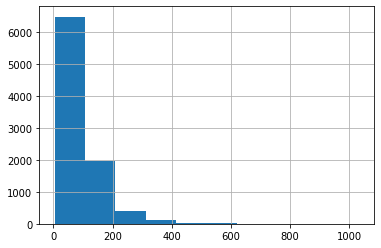

In [ ]:
data['length'] = data['text'].apply(lambda x : len(x.split(' ')))
data.length.hist()

In [ ]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer, TFBertModel,pipeline
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
texts = []
labels = []
text = list(data.text.values)
label = list(data.Label.values)

for i in range(0,len(text),10):
  if (i%1000)==0:
    print(i)
  try:
    encoded_input = tokenizer(text[i:i+10], return_tensors='tf',max_length = 150,  # maximum length of a sentence  (TODO Figure the longest passage length)
      truncation = 'longest_first',padding='max_length'
    )
  
    output = model(encoded_input)
    for j in range(10):
      texts.append(np.copy(np.array(output['last_hidden_state'])[j]))
      labels.append(label[i+j])
  except:
    pass

0
1000
2000
3000
4000
5000
6000
7000
8000


In [ ]:
import numpy as np
len(labels)

9000

In [ ]:
texts = np.array(texts)

In [ ]:
labels = np.array(labels)

In [ ]:
texts.shape

(9000, 150, 768)

In [ ]:
from sklearn.model_selection import train_test_split
text_train, text_test,label_train,label_test = train_test_split(texts,labels,test_size=0.2,random_state=24)

In [ ]:
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
def mod():
  sent_inp = Input(shape=(150, 768))
  X = Bidirectional(LSTM(512, return_sequences=True))(sent_inp)
  
  X = Bidirectional(LSTM(100,return_sequences=True))(X)
  X = Dropout(0.2)(X)
  X = Bidirectional(LSTM(200,return_sequences=True))(X)
  X = Dropout(0.2)(X)
  X = Bidirectional(LSTM(100))(X)
  
  X = Dense(16,activation='relu',kernel_regularizer='l1')(X) 
  out = Dense(1,activation='sigmoid')(X)


  


  
  
  
  
  model = Model(inputs=sent_inp, 
                  outputs=out)
  
  return model


In [ ]:
model = mod()

In [ ]:
texts = None

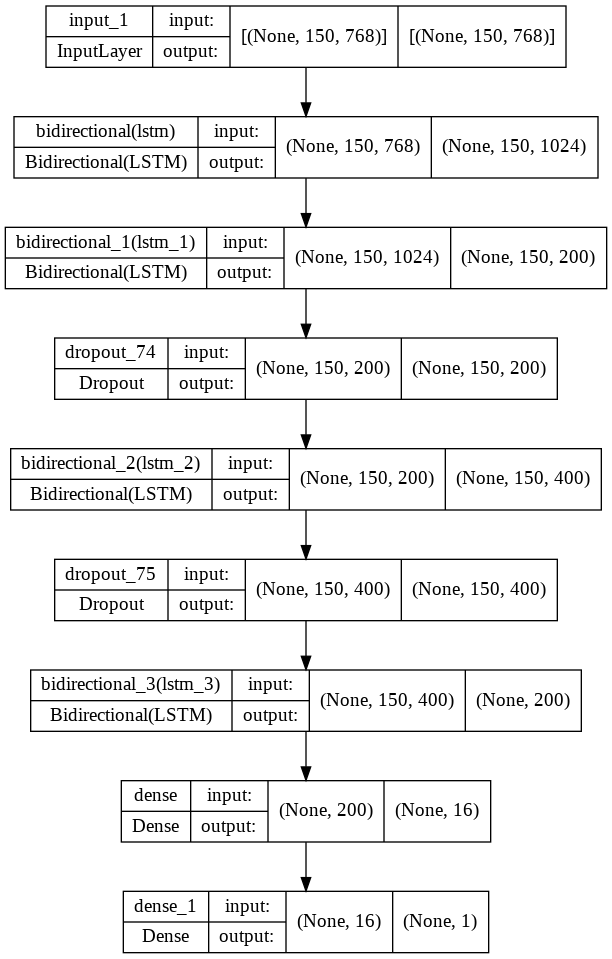

In [ ]:
tf.keras.utils.plot_model(model, to_file='img.png', show_shapes=True)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(text_train,label_train,validation_split=0.15,epochs=15,batch_size=256)

Epoch 1/15
24/24 [==============================] - 32s 818ms/step - loss: 2.8253 - accuracy: 0.7743 - val_loss: 2.3467 - val_accuracy: 0.8685
Epoch 2/15
24/24 [==============================] - 17s 706ms/step - loss: 2.0278 - accuracy: 0.8845 - val_loss: 1.7244 - val_accuracy: 0.9019
Epoch 3/15
24/24 [==============================] - 17s 700ms/step - loss: 1.4610 - accuracy: 0.9067 - val_loss: 1.2500 - val_accuracy: 0.8954
Epoch 4/15
24/24 [==============================] - 17s 702ms/step - loss: 1.0080 - accuracy: 0.9155 - val_loss: 0.8081 - val_accuracy: 0.9278
Epoch 5/15
24/24 [==============================] - 17s 708ms/step - loss: 0.6699 - accuracy: 0.9216 - val_loss: 0.5493 - val_accuracy: 0.9278
Epoch 6/15
24/24 [==============================] - 17s 713ms/step - loss: 0.4528 - accuracy: 0.9239 - val_loss: 0.3880 - val_accuracy: 0.9324
Epoch 7/15
24/24 [==============================] - 17s 710ms/step - loss: 0.3305 - accuracy: 0.9315 - val_loss: 0.3513 - val_accuracy: 0.9287

In [ ]:
pred = model.predict(text_test)

In [ ]:
pred_bin = [1 if pr[0]>=0.5 else 0 for pr in pred  ]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score
accuracy_score(pred_bin,label_test)

0.9311111111111111

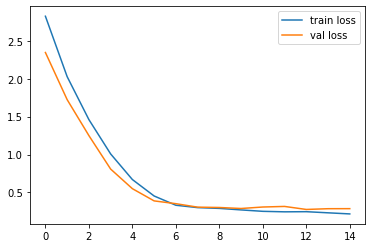

<Figure size 432x288 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('loss')

In [ ]:
model.save('/content/drive/MyDrive/Trip_model_sentimentv2_withoutCuda.h5')